# Description

This notebook shows benchmarking results for different join algorithms. The benchmark was run on Spark in cluster mode, 4G for driver memory, 6G executor memory and cut-off time of 30 minutes (jobs taking more than that were aborted). The goal was to find maximum volume of data that each algorithm can process without either timeouting or running out of memory.

## Synthetic datasets
Following datasets were generated in different sizes (16 clusters with varying number of rows; from 100 rows per cluster up to 50.000.000). Input files were split into `1 + (testDataSize / 1.000.000)` files and stored on HDFS for read, no additional partitioning was done for that data.

*all-to-all*
> Point intervals (from = to), the expected result is a full cartesian join per group.

*all-to-one*
> Database of point intervals and query consisting one interval covering whole database.

*continuous-16*
> Effectively one-to-16, database of point intervals and query spanning for 16 units, no intervals' overlapping.

*one-to-one*
> Both database and query contain point intervals, expected 1:1 results.

*spanning-16*
> Database of point intervals and query intervals of length of 32 with sliding window ([1-33], [2-34], [3-35], ...). Query intervals do overlap.

*spanning-4*
> Similar to _spanning-16_, but with query interval length of 8.

*sparse-16*
> Similar to one-to-one, but query dataset is sparse and cotains only every 16th interval (1/16 of 1:1 dataset's intervals).

## Join algorithms
Driver-based join is represented in the benchmark as single `broadcast-ailist-benchmark`, while proposed partitioned (native) AIList implementation utilizes different variations of data partitioning into buckets. `partitioned-native-ailist-benchmark-N-K` represents running AIList with maximum number of `K` components and `Bucketizer` scaling data by `N` factor (described below). Values from 100 to 100.000 were tested.

## Bucketizer(N)
Bucketizer attempts to split input data into partitions by introducing `_bucket` column, repartitioning data by it and introducing the column to join condition. There is a silent assumption that intervals' values (start and end) are distributed evenly and uniformly.
1. Compute `scale` as `size of the dataset / N`.
2. Compute scaled down values of start and end of each interval.
3. For each integer  of {scaled start, ..., scaled end} create a separate copy of the interval, assign that value to its `_bucket` field.
4. Perform the join (use columns `KEY` (from the input data) and `_bucket` and do equality join).
5. Filter out non-overlapping intervals.
6. Drop the `_bucket` column.
7. Deduplicate the data.
   
## Results
1. Non-distributed algorithm outperformed proposed one in `all-to-all` and `all-to-one` benchmarks.
2. In less of an edge case benchmarks, proposed algorithm scored better potential to scale out.
3. Lesser `N` value (creating more smaller partitions) yields better results than huge ones in most cases. Only `spanning-16` favours bigger partitions.

## Possible further work
1. Evaluate number of components created by the algorithm for different datasets. Check possible optimizations for large number of components.
2. Compute basic data statistics to remove implicit assumption for bucketizer.
3. Compare split solution (separate building database and querying it) with iterative driver-based version of the reference (broadcast) one.

# Benchmark source code
Code below, in the code cells.

In [1]:
%run Common.ipynb

In [2]:
DATA_SUITES = [
    "all-to-all",
    "all-to-one",
    "continuous-16",
    "one-to-one",
    "spanning-4",
    "spanning-16",
    "sparse-16"
]

JOIN_NAMES = [
    "broadcast-ailist-benchmark", 
    "partitioned-native-ailist-benchmark-100-8", 
    "partitioned-native-ailist-benchmark-1000-8", 
    "partitioned-native-ailist-benchmark-10000-8",
    "partitioned-native-ailist-benchmark-100000-8"
]

## Data summary (plot)

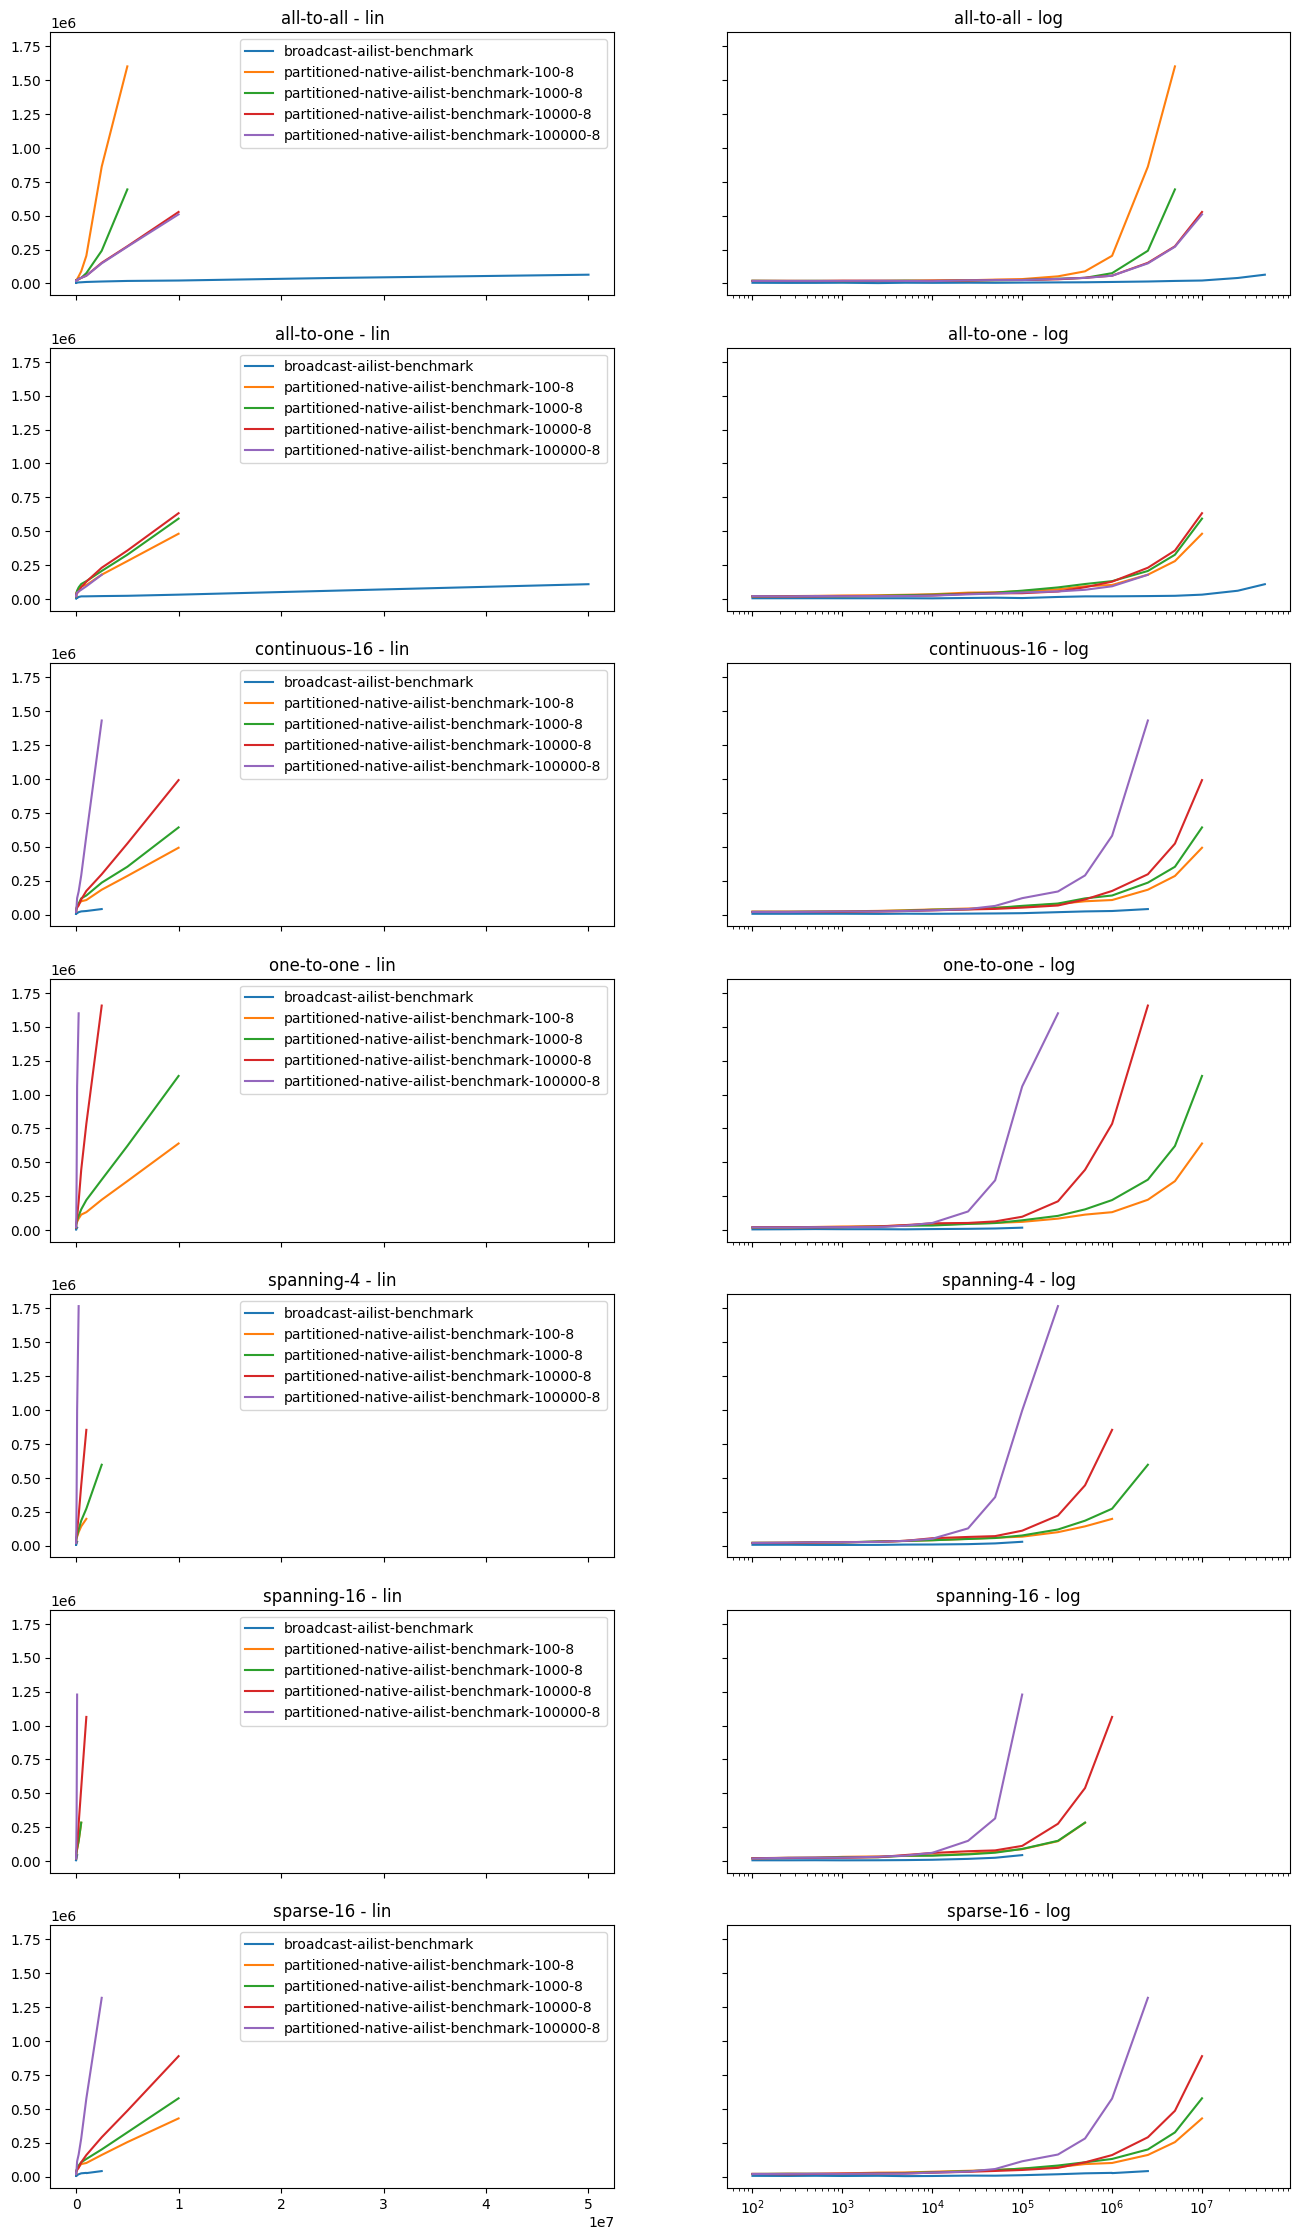

In [3]:
dataset = plot_dataset(
    benchmark_name = "scaling-cluster",
    data_suites = DATA_SUITES, 
    join_names = JOIN_NAMES
)

## Data summary (table)

In [4]:
for data_suite in DATA_SUITES:
    display(dataset.query(f"data_suite == '{data_suite}'").groupby(["data_suite", "join_name"]).max().reset_index()[["data_suite", "join_name", "rows_per_cluster"]])

,data_suite,join_name,rows_per_cluster
0,all-to-all,broadcast-ailist-benchmark,50000000
1,all-to-all,partitioned-native-ailist-benchmark-100-8,5000000
2,all-to-all,partitioned-native-ailist-benchmark-1000-8,5000000
3,all-to-all,partitioned-native-ailist-benchmark-10000-8,10000000
4,all-to-all,partitioned-native-ailist-benchmark-100000-8,10000000


,data_suite,join_name,rows_per_cluster
0,all-to-one,broadcast-ailist-benchmark,50000000
1,all-to-one,partitioned-native-ailist-benchmark-100-8,10000000
2,all-to-one,partitioned-native-ailist-benchmark-1000-8,10000000
3,all-to-one,partitioned-native-ailist-benchmark-10000-8,10000000
4,all-to-one,partitioned-native-ailist-benchmark-100000-8,2500000


,data_suite,join_name,rows_per_cluster
0,continuous-16,broadcast-ailist-benchmark,2500000
1,continuous-16,partitioned-native-ailist-benchmark-100-8,10000000
2,continuous-16,partitioned-native-ailist-benchmark-1000-8,10000000
3,continuous-16,partitioned-native-ailist-benchmark-10000-8,10000000
4,continuous-16,partitioned-native-ailist-benchmark-100000-8,2500000


,data_suite,join_name,rows_per_cluster
0,one-to-one,broadcast-ailist-benchmark,100000
1,one-to-one,partitioned-native-ailist-benchmark-100-8,10000000
2,one-to-one,partitioned-native-ailist-benchmark-1000-8,10000000
3,one-to-one,partitioned-native-ailist-benchmark-10000-8,2500000
4,one-to-one,partitioned-native-ailist-benchmark-100000-8,250000


,data_suite,join_name,rows_per_cluster
0,spanning-4,broadcast-ailist-benchmark,100000
1,spanning-4,partitioned-native-ailist-benchmark-100-8,1000000
2,spanning-4,partitioned-native-ailist-benchmark-1000-8,2500000
3,spanning-4,partitioned-native-ailist-benchmark-10000-8,1000000
4,spanning-4,partitioned-native-ailist-benchmark-100000-8,250000


,data_suite,join_name,rows_per_cluster
0,spanning-16,broadcast-ailist-benchmark,100000
1,spanning-16,partitioned-native-ailist-benchmark-100-8,500000
2,spanning-16,partitioned-native-ailist-benchmark-1000-8,500000
3,spanning-16,partitioned-native-ailist-benchmark-10000-8,1000000
4,spanning-16,partitioned-native-ailist-benchmark-100000-8,100000


,data_suite,join_name,rows_per_cluster
0,sparse-16,broadcast-ailist-benchmark,2500000
1,sparse-16,partitioned-native-ailist-benchmark-100-8,10000000
2,sparse-16,partitioned-native-ailist-benchmark-1000-8,10000000
3,sparse-16,partitioned-native-ailist-benchmark-10000-8,10000000
4,sparse-16,partitioned-native-ailist-benchmark-100000-8,2500000
